## Imports and setup

In [1]:
import os

import numpy as np

from sklearn import datasets as skdatasets

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

from datasets import get_dataset
from models import NCSN, Encoder, Decoder, ScoreVAENet
from losses import NCSNLoss, GaussianPerturbation, BetaVAELoss
from train import ScoreNetTrainer, AETrainer, VAETrainer, ScoreNetAETrainer, ScoreNetVAETrainer
from samplers import AnnealedLangevinDynamics

from utils import get_torch_device

In [2]:
device = get_torch_device()
print(device)

mps


In [3]:
def sample_img(sampler, arg):
    if isinstance(arg, (list, tuple, torch.Size)):
        img = sampler.sample(shape[::-1], epsilon=2e-5).squeeze(0).permute(1, 2, 0).cpu().numpy()
    else:
        img = sampler.sample(arg, epsilon=2e-5).squeeze(0).permute(1, 2, 0).cpu().numpy()
    
    return img

## Toy example

In [3]:
def normalize(ds, scaling_factor=2.0):
    return (ds - ds.mean()) / ds.std() * scaling_factor

def sample_checkerboard(n):
    # https://github.com/ghliu/SB-FBSDE/blob/main/data.py
    n_points = 3 * n
    n_classes = 2
    freq = 5
    x = np.random.uniform(
        -(freq // 2) * np.pi, (freq // 2) * np.pi, size=(n_points, n_classes)
    )
    mask = np.logical_or(
        np.logical_and(np.sin(x[:, 0]) > 0.0, np.sin(x[:, 1]) > 0.0),
        np.logical_and(np.sin(x[:, 0]) < 0.0, np.sin(x[:, 1]) < 0.0),
    )
    y = np.eye(n_classes)[1 * mask]
    x0 = x[:, 0] * y[:, 0]
    x1 = x[:, 1] * y[:, 0]
    sample = np.concatenate([x0[..., None], x1[..., None]], axis=-1)
    sqr = np.sum(np.square(sample), axis=-1)
    idxs = np.where(sqr == 0)
    sample = np.delete(sample, idxs, axis=0)

    return sample

def load_twodim(num_samples: int, dataset: str, dimension: int = 2):
    if dataset == "gaussian_centered":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample*2 - 1

    if dataset == "gaussian_shift":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample + 1.5

    if dataset == "circle":
        X, y = skdatasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=0.5
        )
        sample = X * 4

    if dataset == "scurve":
        X, y = skdatasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "moon":
        X, y = skdatasets.make_moons(n_samples=num_samples, noise=0.0, random_state=None)
        sample = normalize(X)

    if dataset == "swiss_roll":
        X, y = skdatasets.make_swiss_roll(
            n_samples=num_samples, noise=0.0, random_state=None, hole=True
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "checkerboard":
        sample = normalize(sample_checkerboard(num_samples))

    return torch.tensor(sample).float()


class TwoDimDataClass(Dataset):
    def __init__(self, dataset_type: str, N: int, batch_size: int, dimension=2):

        self.X = load_twodim(N, dataset_type, dimension=dimension)
        self.name = dataset_type
        self.batch_size = batch_size
        self.dimension = 2

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
        )

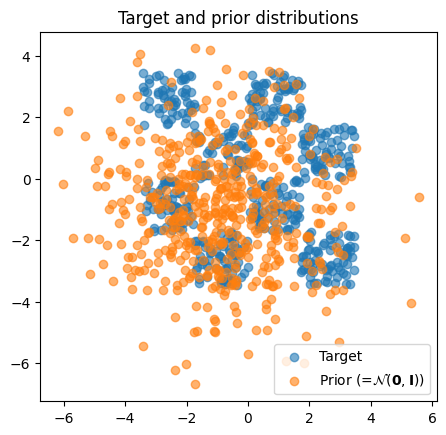

In [4]:
target_ds = TwoDimDataClass(dataset_type='checkerboard',
                            N=int(1e6),
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=int(1e6),
                           batch_size=256)

train_loader = DataLoader(target_ds, batch_size=8196 * 2)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(target_ds[:500][:, 0], target_ds[:500][:, 1], alpha=0.6)
ax.scatter(prior_ds[:500][:, 0], prior_ds[:500][:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', r'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

In [5]:
class ToyScoreNet(nn.Module):
  def __init__(self, n_steps):
    super().__init__()
    self.linear_model1 = nn.Sequential(
        nn.Linear(2, 256),
        nn.Dropout(0.3),
        nn.GELU()
    )
    self.embedding_layer = nn.Embedding(n_steps, 256)
    self.linear_model2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.Dropout(0.3),
        nn.GELU(),
        nn.Linear(512, 512),
        nn.Dropout(0.3),
        nn.GELU(),
        nn.Linear(512, 2),
    )

  def forward(self, x, idx):
    out = self.linear_model1(x)
    embed = self.embedding_layer(idx)
    return self.linear_model2(out + embed)

In [6]:
L = 12
sigmas = torch.exp(torch.linspace(torch.log(torch.tensor(1e1)), torch.log(torch.tensor(1e-3)), L)).to(device)

model = ToyScoreNet(L)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

perturbation = GaussianPerturbation()
loss_fn = NCSNLoss(perturbation, sigmas, coeff_func=lambda s: s**2)

trainer = ScoreNetTrainer(train_loader, model, device)
sampler = AnnealedLangevinDynamics(model, sigmas, device)

In [7]:
if os.path.exists("model_toy.pth"):
    model.load_state_dict(torch.load("model_toy.pth"))
else:
    trainer.train(loss_fn, optimizer, epochs=120, verbose=True)
    torch.save(model.state_dict(), "model_toy.pth")

In [8]:
# n_samples = 2 ** 12
# shape = (n_samples, 2)
# gen = sampler.sample(shape, epsilon=1e-6).cpu().numpy()

# fig, ax = plt.subplots(1,1)
# ax.scatter(target_ds[:n_samples][:,0], target_ds[:n_samples][:,1], alpha=0.3, label="target distribution")
# ax.scatter(gen[:,0], gen[:,1], alpha=0.3, label="samples")
# ax.legend()
# plt.show()

## Annealed MNIST

In [3]:
B = 128

train_loader, test_loader = get_dataset("mnist", batch_size=B, num_workers=2, pin_memory=False)
shape = (28, 28, 1)

In [9]:
sigma0 = 1
sigmaL = 0.01
L = 10

sigmas = torch.exp(torch.linspace(np.log(sigma0), np.log(sigmaL), L)).to(device)
print(sigmas)

tensor([1.0000, 0.5995, 0.3594, 0.2154, 0.1292, 0.0774, 0.0464, 0.0278, 0.0167,
        0.0100], device='mps:0')


In [11]:
model = NCSN(shape, L, filters=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(summary(model, [(1, *shape[::-1]), (1,)], dtypes=[torch.float, torch.long]))

Layer (type:depth-idx)                                                           Output Shape              Param #
NCSN                                                                             [1, 1, 28, 28]            --
├─Conv2d: 1-1                                                                    [1, 64, 28, 28]           640
├─ConditionalSequential: 1-2                                                     [1, 128, 14, 14]          2,075,584
│    └─ConditionalResidualBlock: 2-1                                             [1, 64, 28, 28]           75,776
│    │    └─ConditionalInstanceNorm2dPlus: 3-1                                   [1, 64, 28, 28]           1,920
├─ConditionalSequential: 1-122                                                   --                        (recursive)
│    └─ELU: 2-2                                                                  [1, 64, 28, 28]           --
├─ConditionalSequential: 1-34                                                    --        

In [12]:
perturbation = GaussianPerturbation()
loss_fn = NCSNLoss(perturbation, sigmas, coeff_func=lambda s: s**2)

In [13]:
if os.path.exists("model_mnist.pth"):
    model.load_state_dict(torch.load("model_mnist.pth"))

In [14]:
trainer = ScoreNetTrainer(train_loader, model, device)
sampler = AnnealedLangevinDynamics(model, sigmas, device)

In [16]:
# for e in range(0):
#     trainer.train(loss_fn, optimizer, epochs=4, verbose=True, reset=False)
    
#     img = sample_img(sampler, shape)
#     plt.imshow(img, cmap="gray")
#     plt.show()
# torch.save(model.state_dict(), "model_mnist.pth")

In [17]:
# img = sample_img(sampler, shape)
# plt.imshow(img, cmap="gray")
# plt.show()

## AE / VAE Model

In [4]:
B = 128

train_loader, test_loader = get_dataset("mnist", batch_size=B, num_workers=2, pin_memory=False)
shape = (28, 28, 1)

In [5]:
latent_dim = 12

encoder = Encoder(shape[::-1], latent_dim, 1, conv_layers=5, mlp_layers=[256, 128, 64])
decoder = Decoder(encoder.conv_shape, shape[2], latent_dim, convT_layers=5, mlp_layers=[64, 128, 256])
model = nn.ModuleDict({'enc': encoder, 'dec': decoder})

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# loss = BetaVAELoss(0)
loss = nn.MSELoss(reduction="sum")

# trainer = VAETrainer(train_loader, encoder, decoder, device)
trainer = AETrainer(train_loader, encoder, decoder, device)

trainer.train(loss, optimizer, epochs=120, verbose=True)

  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 1 (Loss: 5645.9957)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 2 (Loss: 2813.8982)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 3 (Loss: 2270.4133)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 4 (Loss: 1987.7934)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 5 (Loss: 1720.5873)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 6 (Loss: 1571.6167)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 7 (Loss: 1477.1886)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 8 (Loss: 1400.2361)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 9 (Loss: 1327.9347)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 10 (Loss: 1261.3501)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 11 (Loss: 1196.0089)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 12 (Loss: 1153.7944)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 13 (Loss: 1118.2181)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 14 (Loss: 1079.7053)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 15 (Loss: 1056.2791)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 16 (Loss: 1036.9582)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 17 (Loss: 1013.5342)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 18 (Loss: 998.8928)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 19 (Loss: 980.7021)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 20 (Loss: 966.6678)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 21 (Loss: 952.7629)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 22 (Loss: 941.8174)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 23 (Loss: 935.6878)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 24 (Loss: 914.1515)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 25 (Loss: 909.8050)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 26 (Loss: 897.2226)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 27 (Loss: 887.0987)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 28 (Loss: 879.3474)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 29 (Loss: 866.8812)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 30 (Loss: 856.6711)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 31 (Loss: 846.9943)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 32 (Loss: 842.9733)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 33 (Loss: 829.4289)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 34 (Loss: 825.0740)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 35 (Loss: 814.2837)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 36 (Loss: 808.7123)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 37 (Loss: 798.0527)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 38 (Loss: 793.5483)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 39 (Loss: 787.7027)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 40 (Loss: 776.6879)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 41 (Loss: 775.7313)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 42 (Loss: 770.0432)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 43 (Loss: 760.4793)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 44 (Loss: 755.1937)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 45 (Loss: 751.5720)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 46 (Loss: 740.4452)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 47 (Loss: 737.9235)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 48 (Loss: 738.3684)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 49 (Loss: 725.5859)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 50 (Loss: 720.3727)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 51 (Loss: 714.7928)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 52 (Loss: 710.5917)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 53 (Loss: 704.6545)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 54 (Loss: 696.7644)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 55 (Loss: 691.4584)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 56 (Loss: 684.4173)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 57 (Loss: 682.9584)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 58 (Loss: 675.2347)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 59 (Loss: 670.3909)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 60 (Loss: 667.3169)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 61 (Loss: 663.4634)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 62 (Loss: 655.9482)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 63 (Loss: 654.0506)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 64 (Loss: 645.4940)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 65 (Loss: 645.4574)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 66 (Loss: 640.7675)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 67 (Loss: 641.3150)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 68 (Loss: 635.2743)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 69 (Loss: 629.1984)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 70 (Loss: 627.7140)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 71 (Loss: 628.4798)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 72 (Loss: 618.7023)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 73 (Loss: 618.1511)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 74 (Loss: 614.7151)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 75 (Loss: 613.3850)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 76 (Loss: 604.6944)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 77 (Loss: 607.1670)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 78 (Loss: 604.5928)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 79 (Loss: 602.2579)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 80 (Loss: 598.1322)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 81 (Loss: 596.7520)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 82 (Loss: 592.7421)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 83 (Loss: 592.2869)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 84 (Loss: 587.4357)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 85 (Loss: 589.0230)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 86 (Loss: 586.9138)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 87 (Loss: 582.1121)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 88 (Loss: 579.2195)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 89 (Loss: 578.7356)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 90 (Loss: 579.2198)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 91 (Loss: 569.7987)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 92 (Loss: 573.7634)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 93 (Loss: 567.7083)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 94 (Loss: 569.8968)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 95 (Loss: 570.0705)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 96 (Loss: 561.8034)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 97 (Loss: 563.9237)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 98 (Loss: 558.8026)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 99 (Loss: 560.2593)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 100 (Loss: 556.3569)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 101 (Loss: 553.7955)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 102 (Loss: 551.0075)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 103 (Loss: 552.5088)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 104 (Loss: 548.5896)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 105 (Loss: 551.1736)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 106 (Loss: 546.2782)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 107 (Loss: 545.5561)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 108 (Loss: 543.5453)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 109 (Loss: 539.0296)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 110 (Loss: 542.0549)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 111 (Loss: 540.1446)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 112 (Loss: 535.1466)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 113 (Loss: 532.4666)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 114 (Loss: 535.0990)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 115 (Loss: 535.4160)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 116 (Loss: 531.3419)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 117 (Loss: 529.4895)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 118 (Loss: 528.1442)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 119 (Loss: 524.8001)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 120 (Loss: 526.3596)


tensor([5645.9956, 2813.8982, 2270.4133, 1987.7935, 1720.5873, 1571.6167,
        1477.1886, 1400.2361, 1327.9347, 1261.3501, 1196.0089, 1153.7944,
        1118.2181, 1079.7053, 1056.2791, 1036.9583, 1013.5342,  998.8928,
         980.7021,  966.6678,  952.7629,  941.8174,  935.6877,  914.1516,
         909.8050,  897.2226,  887.0987,  879.3474,  866.8812,  856.6711,
         846.9943,  842.9733,  829.4289,  825.0740,  814.2838,  808.7123,
         798.0527,  793.5483,  787.7027,  776.6879,  775.7313,  770.0432,
         760.4792,  755.1937,  751.5720,  740.4453,  737.9235,  738.3684,
         725.5859,  720.3727,  714.7928,  710.5917,  704.6545,  696.7643,
         691.4584,  684.4173,  682.9584,  675.2347,  670.3909,  667.3168,
         663.4634,  655.9482,  654.0506,  645.4940,  645.4574,  640.7675,
         641.3150,  635.2743,  629.1984,  627.7141,  628.4799,  618.7023,
         618.1511,  614.7150,  613.3850,  604.6944,  607.1670,  604.5928,
         602.2579,  598.1323,  596.752

In [6]:
sigma0 = 1
sigmaL = 0.01
L = 10

sigmas = torch.exp(torch.linspace(np.log(sigma0), np.log(sigmaL), L)).to(device)
print(sigmas)

tensor([1.0000, 0.5995, 0.3594, 0.2154, 0.1292, 0.0774, 0.0464, 0.0278, 0.0167,
        0.0100], device='mps:0')


In [7]:
score_vae_net = ScoreVAENet(latent_dim, L)
optimizer = torch.optim.AdamW(score_vae_net.parameters(), lr=1e-3, weight_decay=1e-4)

In [8]:
perturbation = GaussianPerturbation()
loss_fn = NCSNLoss(perturbation, sigmas, coeff_func=lambda s: s**2)

# trainer = ScoreNetVAETrainer(train_loader, score_vae_net, encoder, device=device)
trainer = ScoreNetAETrainer(train_loader, score_vae_net, encoder, device=device)

sampler = AnnealedLangevinDynamics(score_vae_net, sigmas, device)

In [9]:
trainer.train(loss_fn, optimizer, epochs=12, verbose=True, reset=False)

  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 1 (Loss: 5.6120)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 2 (Loss: 5.3673)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 3 (Loss: 5.2990)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 4 (Loss: 5.2815)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 5 (Loss: 5.2666)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 6 (Loss: 5.2643)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 7 (Loss: 5.2609)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 8 (Loss: 5.2634)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 9 (Loss: 5.2222)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 10 (Loss: 5.2336)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 11 (Loss: 5.2299)


  0%|          | 0/468 [00:00<?, ?batch/s]

Epoch 12 (Loss: 5.2312)


tensor([5.6120, 5.3673, 5.2990, 5.2815, 5.2666, 5.2643, 5.2609, 5.2634, 5.2222,
        5.2336, 5.2299, 5.2312], device='mps:0')

In [10]:
N = 10

with torch.no_grad():
    z = sampler.sample((N, latent_dim), epsilon=2e-5)
    # z = torch.randn_like(z)
    
    imgs = decoder(z).permute(0, 2, 3, 1).cpu().numpy()

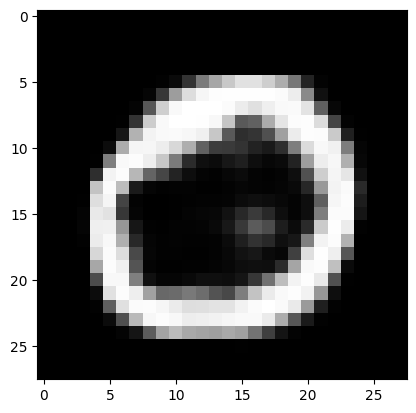

In [14]:
img = imgs[7]
plt.imshow(img, cmap="gray")
plt.show()